In [123]:
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2 # L2-regularisation

import time
import sklearn
import numpy as np

import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


import os

ROOT_PATH = os.getcwd()
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

TRAIN_SIZE = 36000
VAL_SIZE = 5000
TEST_SIZE = 1000

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11374949806832336473
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7152897229
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4042621802061122961
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [124]:
def split_labels(data: DataFrame):
    label = data['label']
    data = data.drop(columns='label')
    return (data, label)

In [125]:
source_df = pd.read_csv(os.path.join(ROOT_PATH, 'train.csv'))
source_shuffled_df = sklearn.utils.shuffle(source_df)
(source_x_df, source_ynum_df) = split_labels(source_shuffled_df)

source_xpix = source_x_df.values.astype('float32') / 255
source_ynum = source_ynum_df.values

source_y = to_categorical(source_ynum,10)
source_x = source_xpix.reshape(source_xpix.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 1)
print("Loaded train images: ", source_x.shape[0])


Loaded train images:  42000


In [126]:
control_df = pd.read_csv(os.path.join(ROOT_PATH, 'test.csv'))
control_xpix = control_df.values.astype('float32') / 255
control_x = control_xpix.reshape(control_xpix.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 1)

print("Loaded test images: ", control_x.shape[0])

Loaded test images:  28000


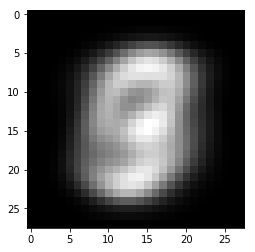

In [127]:
total_x = np.append(control_x, source_x, axis = 0)
mean_x = np.mean(total_x, axis = 0)

source_norm_x = (source_x - mean_x)
control_norm_x = (control_x - mean_x)

%matplotlib inline
image = mean_x.reshape((IMAGE_WIDTH,IMAGE_HEIGHT))*255
imshow(image, cmap='gray')


In [128]:
# split to train, val, test
train_data = source_norm_x[:TRAIN_SIZE]
train_label = source_y[:TRAIN_SIZE]

val_data = source_norm_x[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]
val_label = source_y[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]

test_data = source_norm_x[TRAIN_SIZE+VAL_SIZE:TRAIN_SIZE+VAL_SIZE+TEST_SIZE]
test_label = source_y[TRAIN_SIZE+VAL_SIZE:TRAIN_SIZE+VAL_SIZE+TEST_SIZE]

In [129]:
# define model
model = models.Sequential()
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.normalization.BatchNormalization(axis=-1))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.normalization.BatchNormalization(axis=-1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.normalization.BatchNormalization(axis=-1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
# Fully connected layer
model.add(layers.normalization.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))


learning_rate_reduction =  ReduceLROnPlateau(monitor='val_acc',
                                                patience=3,
                                                verbose=1,
                                                factor=0.25,
                                                min_lr=0.00001)

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [130]:
#define data generators

BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image
        width_shift_range=3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=3,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_data, train_label, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(val_data, val_label, batch_size=BATCH_SIZE)

In [131]:
# train model
number_of_epochs = 40
start_time = time.time()
history = model.fit_generator(train_generator, steps_per_epoch=60000 // BATCH_SIZE, epochs=number_of_epochs,
                          validation_data=test_generator, validation_steps=VAL_SIZE // BATCH_SIZE,
                                  callbacks=[learning_rate_reduction])
training_time = time.time() - start_time
print("Training time per epoch", training_time/number_of_epochs)

Epoch 1/40
3750/3750 [==============================] - 20s 5ms/step - loss: 0.2508 - acc: 0.9246 - val_loss: 0.0374 - val_acc: 0.9890
Epoch 2/40
3750/3750 [==============================] - 18s 5ms/step - loss: 0.1053 - acc: 0.9681 - val_loss: 0.0300 - val_acc: 0.9912
Epoch 3/40
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0765 - acc: 0.9761 - val_loss: 0.0223 - val_acc: 0.9926
Epoch 4/40
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0666 - acc: 0.9801 - val_loss: 0.0155 - val_acc: 0.9942
Epoch 5/40
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0589 - acc: 0.9824 - val_loss: 0.0183 - val_acc: 0.9948
Epoch 6/40
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0504 - acc: 0.9845 - val_loss: 0.0147 - val_acc: 0.9944
Epoch 7/40
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0452 - acc: 0.9860 - val_loss: 0.0175 - val_acc: 0.9946
Epoch 8/40
3750/3750 [==============================] -

In [132]:
#predict
predict_labels = model.predict_classes(control_norm_x)

In [133]:
# merge together and save
idLabel = pd.Series(data=np.arange(1, predict_labels.size + 1), name='ImageId')
serieLabel = pd.Series(data=predict_labels, name='Label')

pr_df = pd.concat([idLabel, serieLabel], axis=1)
path_for_prediction = os.path.join(ROOT_PATH, 'prediction.csv')
result = pr_df.to_csv(path_for_prediction, index=False)

1000/1000 [==============================] - 0s 42us/step
[0.011696326436620438, 0.998]


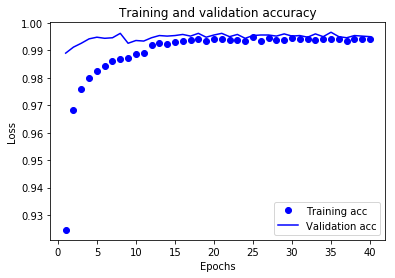

[0.011696326436620438, 0.998]


In [134]:
# print history
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
# print test result
result = model.evaluate(test_data, test_label)
print(result)

plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(result)